In [124]:
import os
from pprint import pprint

import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

### EDA에 사용할 함수

In [2]:
def summarize_group(df, group_by_columns):
    # 데이터프레임을 그룹화
    grouped_df = df.groupby(group_by_columns)
    
    # 결과를 저장할 리스트 초기화
    results = []
    
    # 그룹화된 데이터프레임의 내용을 확인하는 코드
    for name, group in grouped_df:
        # 그룹의 갯수 계산
        group_count = group.shape[0]
        
        # 'target' 변수의 'AdNormal' 비율과 갯수 계산
        adnormal_count = group['target'].value_counts().get('AbNormal', 0)
        adnormal_ratio = adnormal_count / group_count
        
        # 결과 리스트에 추가
        results.append([name, adnormal_count, adnormal_ratio, group_count])
    
    # 결과 리스트를 데이터프레임으로 변환
    results_df = pd.DataFrame(results, columns=['group', "'AdNormal' count", 'ratio', 'Total'])
    
    # 그룹화된 변수들의 이름을 제목행으로 출력
    print(f"Grouped by: {', '.join(group_by_columns)}")
    print()
    # 데이터프레임 출력
    print(results_df)

# 예시코드
# summarize_grouped_data(train_data, ['1st Pressure Collect Result_AutoClave', '1st Pressure Unit Time_AutoClave'])

In [3]:
RANDOM_STATE = 110

train_data = pd.read_csv("C:/Users/KimDongyoung/Desktop/git_LGaimers5/Lg_aimers5/data/train_data.csv")
test_data = pd.read_csv("C:/Users/KimDongyoung/Desktop/git_LGaimers5/Lg_aimers5/data/test_data.csv")

In [4]:
# 'Dam'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='_Dam').columns

# 필터링된 열 이름 출력
print("<Dam 공정 관련 변수>")
for col in Process_Desc_col:
    print(col)

<Dam 공정 관련 변수>
CURE END POSITION X Collect Result_Dam
CURE END POSITION Z Collect Result_Dam
CURE END POSITION Θ Collect Result_Dam
CURE SPEED Collect Result_Dam
CURE START POSITION X Collect Result_Dam
CURE START POSITION Θ Collect Result_Dam
DISCHARGED SPEED OF RESIN Collect Result_Dam
DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam
DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam
DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam
Dispense Volume(Stage1) Collect Result_Dam
Dispense Volume(Stage2) Collect Result_Dam
Dispense Volume(Stage3) Collect Result_Dam
HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam
HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam
HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam
HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam
HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam
HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam
HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam
HEAD NORMAL COORDINATE Z AXIS(

Dispenser_num 변수 정리

In [5]:
train_data['Dispenser_num'].value_counts()

Dispenser_num
#1    25011
#2    15461
#0       34
Name: count, dtype: int64

In [6]:
# Dispenser_num 값에 따라 원핫인코딩 변수 생성
train_data['Dispenser_1'] = train_data['Dispenser_num'].apply(lambda x: 1 if x == '#1' else 0)
train_data['Dispenser_2'] = train_data['Dispenser_num'].apply(lambda x: 1 if x == '#2' else 0)

test_data['Dispenser_1'] = test_data['Dispenser_num'].apply(lambda x: 1 if x == '#1' else 0)
test_data['Dispenser_2'] = test_data['Dispenser_num'].apply(lambda x: 1 if x == '#2' else 0)

# 결과 확인
print(train_data[['Dispenser_num', 'Dispenser_1', 'Dispenser_2']].head(5))

# 불필요한 변수 제거
train_data.drop(['Dispenser_num'], axis=1, inplace=True)
test_data.drop(['Dispenser_num'], axis=1, inplace=True)

  Dispenser_num  Dispenser_1  Dispenser_2
0            #1            1            0
1            #1            1            0
2            #2            0            1
3            #2            0            1
4            #1            1            0


In [7]:
train_data

,Model.Suffix,Workorder,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION X Collect Result_Dam,CURE START POSITION Θ Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,...,HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2,Head Purge Position Z Collect Result_Fill2,Machine Tact time Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,WorkMode Collect Result_Fill2,target,Dispenser_1,Dispenser_2
0,AJX75334505,4F1XA938-1,240,2.5,-90,100,1030,-90,16,14.9,...,243.7,114.612,19.9,7,127,1,NaN,Normal,1,0
1,AJX75334505,3KPM0016-2,240,2.5,-90,70,1030,-90,10,21.3,...,243.7,85.000,19.6,7,185,1,0.0,Normal,1,0
2,AJX75334501,4E1X9167-1,1000,12.5,90,85,280,90,16,14.7,...,243.5,114.612,19.8,10,73,1,NaN,Normal,0,1
3,AJX75334501,3K1X0057-1,1000,12.5,90,70,280,90,10,21.3,...,243.5,85.000,19.9,12,268,1,0.0,Normal,0,1
4,AJX75334501,3HPM0007-1,240,2.5,-90,70,1030,-90,10,9.7,...,243.7,85.000,19.7,8,121,1,0.0,Normal,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40501,AJX75334501,3J1XF434-2,240,2.5,-90,70,1030,-90,10,17.0,...,243.7,85.000,19.2,1,318,1,0.0,Normal,1,0
40502,AJX75334501,4E1XC796-1,1000,12.5,90,100,280,90,16,14.9,...,243.5,114.612,20.5,14,197,1,NaN,Normal,0,1
40503,AJX75334501,4C1XD438-1,240,2.5,-90,100,1030,-90,16,14.2,...,243.7,85.000,19.7,1,27,1,NaN,Normal,1,0
40504,AJX75334501,3I1XA258-1,1000,12.5,90,70,280,90,10,9.7,...,243.5,85.000,20.1,13,117,1,0.0,Normal,0,1


target 변수 0,1로 변환

In [8]:
# 타겟 변수를 0과 1로 변환
train_data['target_binary'] = train_data['target'].apply(lambda x: 1 if x == 'AbNormal' else 0)

# Workorder 변수의 값에 대한 타겟 변수 비율 계산
workorder_target_ratio = train_data.groupby('Workorder')['target_binary'].mean()

# 파생 변수 생성 함수
def create_derived_variable(row, ratio_dict, threshold):
    return 1 if ratio_dict.get(row['Workorder'], 0) >= threshold else 0

# 파생 변수 생성
train_data['Workorder_0.9'] = train_data.apply(create_derived_variable, axis=1, ratio_dict=workorder_target_ratio, threshold=0.9)
train_data['Workorder_0.7'] = train_data.apply(create_derived_variable, axis=1, ratio_dict=workorder_target_ratio, threshold=0.7)
train_data['Workorder_0.5'] = train_data.apply(create_derived_variable, axis=1, ratio_dict=workorder_target_ratio, threshold=0.5)
train_data['Workorder_0.3'] = train_data.apply(create_derived_variable, axis=1, ratio_dict=workorder_target_ratio, threshold=0.3)

test_data['Workorder_0.9'] = test_data.apply(create_derived_variable, axis=1, ratio_dict=workorder_target_ratio, threshold=0.9)
test_data['Workorder_0.7'] = test_data.apply(create_derived_variable, axis=1, ratio_dict=workorder_target_ratio, threshold=0.7)
test_data['Workorder_0.5'] = test_data.apply(create_derived_variable, axis=1, ratio_dict=workorder_target_ratio, threshold=0.5)
test_data['Workorder_0.3'] = train_data.apply(create_derived_variable, axis=1, ratio_dict=workorder_target_ratio, threshold=0.3)



In [9]:
train_data['Workorder_0.3'].value_counts()

Workorder_0.3
0    40351
1      155
Name: count, dtype: int64

In [10]:
# 불필요한 변수 제거
train_data.drop(['target_binary'], axis=1, inplace=True)

# train_data.drop(['Workorder', 'target_binary'], axis=1, inplace=True)
# test_data.drop(['Workorder'], axis=1, inplace=True)

In [11]:
train_data.columns.to_list()

['Model.Suffix',
 'Workorder',
 'CURE END POSITION X Collect Result_Dam',
 'CURE END POSITION Z Collect Result_Dam',
 'CURE END POSITION Θ Collect Result_Dam',
 'CURE SPEED Collect Result_Dam',
 'CURE START POSITION X Collect Result_Dam',
 'CURE START POSITION Θ Collect Result_Dam',
 'DISCHARGED SPEED OF RESIN Collect Result_Dam',
 'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam',
 'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam',
 'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam',
 'Dispense Volume(Stage1) Collect Result_Dam',
 'Dispense Volume(Stage2) Collect Result_Dam',
 'Dispense Volume(Stage3) Collect Result_Dam',
 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam',
 'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam',
 'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam',
 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam',
 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam',
 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_D

receip가 들어간 변수들 하나로 합쳐주기

In [12]:
# 'receipt'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='Receip').columns

# 필터링된 열 이름 출력
print("<Dam 공정 관련 변수>")
for col in Process_Desc_col:
    print(col)

<Dam 공정 관련 변수>
Receip No Collect Result_Dam
Receip No Collect Result_Fill1
Receip No Collect Result_Fill2


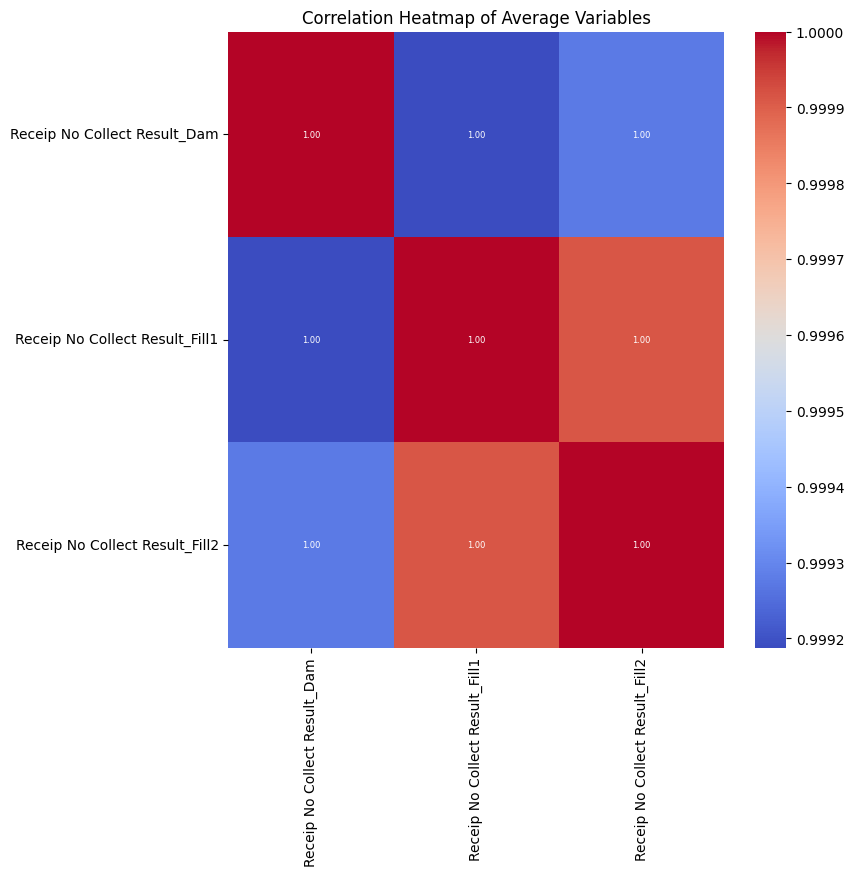

In [13]:
# 상관계수
variables = [
    'Receip No Collect Result_Dam',
    'Receip No Collect Result_Fill1',
    'Receip No Collect Result_Fill2'
]

# Compute the correlation matrix
correlation_matrix = train_data[variables].corr()

# Set the size of the plot
plt.figure(figsize=(8, 8))

# Create a heatmap of the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 6})

# Set the title of the heatmap
plt.title("Correlation Heatmap of Average Variables")

# Display the plot
plt.show()

In [14]:
# 파생변수 생성: 3개의 컬럼 값이 모두 동일하면 해당 값을 저장, 아니면 diff
train_data['Receip_No'] = train_data.apply(
    lambda row: row['Receip No Collect Result_Dam'] if (row['Receip No Collect Result_Dam'] == row['Receip No Collect Result_Fill1'] == row['Receip No Collect Result_Fill2']) else 0,
    axis=1
)
test_data['Receip_No'] = test_data.apply(
    lambda row: row['Receip No Collect Result_Dam'] if (row['Receip No Collect Result_Dam'] == row['Receip No Collect Result_Fill1'] == row['Receip No Collect Result_Fill2']) else 0,
    axis=1
)

train_data['Receip_No'].value_counts()

Receip_No
1     39276
6       980
9        96
17       86
3        64
0         4
Name: count, dtype: int64

In [15]:
columns_to_drop = ['Receip No Collect Result_Dam', 'Receip No Collect Result_Fill1', 'Receip No Collect Result_Fill2']

train_data = train_data.drop(columns=columns_to_drop, inplace=False)
test_data = test_data.drop(columns=columns_to_drop, inplace=False)

Workorder 변수 

In [16]:
# 'Workorder' 열에서 '-' 다음 숫자 값 추출 및 '000' 제거
train_data['Workorder'] = train_data['Workorder'].str.replace(r'-(\d+)', lambda x: '-' + x.group(1).lstrip('0'), regex=True)
test_data['Workorder'] = test_data['Workorder'].str.replace(r'-(\d+)', lambda x: '-' + x.group(1).lstrip('0'), regex=True)

Workmode 변수

In [17]:
# WorkMode Collect Result_Dam의 이름을 WorkMode Collect Result로 변경
train_data = train_data.rename(columns={'WorkMode Collect Result_Dam': 'WorkMode Collect Result'})
test_data = test_data.rename(columns={'WorkMode Collect Result_Dam': 'WorkMode Collect Result'})

# WorkMode Collect Result_Fill1, WorkMode Collect Result_Fill2 열 드롭
train_data = train_data.drop(columns=['WorkMode Collect Result_Fill1', 'WorkMode Collect Result_Fill2'])
test_data = test_data.drop(columns=['WorkMode Collect Result_Fill1', 'WorkMode Collect Result_Fill2'])

# WorkMode Collect Result 열의 값이 7인 행을 1로 변경
train_data['WorkMode Collect Result'] = train_data['WorkMode Collect Result'].replace(7, 1)
test_data['WorkMode Collect Result'] = test_data['WorkMode Collect Result'].replace(7, 1)

# WorkMode Collect Result 열의 결측값을 0으로 채움
train_data['WorkMode Collect Result'] = train_data['WorkMode Collect Result'].fillna(0)
test_data['WorkMode Collect Result'] = test_data['WorkMode Collect Result'].fillna(0)

In [18]:
test_data['WorkMode Collect Result'].value_counts()
train_data['WorkMode Collect Result'].value_counts()

WorkMode Collect Result
0.0    24059
1.0    16447
Name: count, dtype: int64

Pallete ID 변수

In [19]:
# 결과 확인
summarize_group(train_data,[
    'PalletID Collect Result_Dam'
    , 'PalletID Collect Result_Fill1'
    , 'PalletID Collect Result_Fill2'])

Grouped by: PalletID Collect Result_Dam, PalletID Collect Result_Fill1, PalletID Collect Result_Fill2

           group  'AdNormal' count     ratio  Total
0      (1, 1, 1)               162  0.051494   3146
1      (1, 1, 4)                 1  1.000000      1
2      (1, 1, 7)                 1  1.000000      1
3      (1, 1, 9)                 1  1.000000      1
4      (1, 2, 2)                 1  1.000000      1
..           ...               ...       ...    ...
87  (16, 10, 10)                 1  1.000000      1
88  (16, 15, 15)                 1  1.000000      1
89   (16, 16, 8)                 1  1.000000      1
90  (16, 16, 11)                 1  1.000000      1
91  (16, 16, 16)               110  0.062007   1774

[92 rows x 4 columns]


In [20]:
# 세 변수의 값이 동일하면 해당 값을 가져가고, 하나라도 일치하지 않으면 0의 값을 가지는 파생 변수 생성 함수
def create_palletid_collect_result(df):
    df['PalletID_Collect_Result'] = df.apply(
        lambda row: row['PalletID Collect Result_Dam'] 
                    if (row['PalletID Collect Result_Dam'] == row['PalletID Collect Result_Fill1'] == row['PalletID Collect Result_Fill2']) 
                    else 0, 
        axis=1
    )

# 함수 적용
create_palletid_collect_result(train_data)
create_palletid_collect_result(test_data)

In [21]:
# 제거할 변수 목록
columns_to_drop = [
    'PalletID Collect Result_Dam',
    'PalletID Collect Result_Fill1',
    'PalletID Collect Result_Fill2'
]

# 변수 제거
train_data.drop(columns=columns_to_drop, inplace=True)
test_data.drop(columns=columns_to_drop, inplace=True)

Production Qty 변수

In [22]:
# 결과 확인
summarize_group(train_data,[
    'Production Qty Collect Result_Dam'
    , 'Production Qty Collect Result_Fill1'
    , 'Production Qty Collect Result_Fill2'])

Grouped by: Production Qty Collect Result_Dam, Production Qty Collect Result_Fill1, Production Qty Collect Result_Fill2

               group  'AdNormal' count     ratio  Total
0          (0, 0, 0)                13  0.141304     92
1         (0, 0, 12)                 1  1.000000      1
2        (0, 0, 300)                 1  1.000000      1
3          (0, 2, 2)                 1  1.000000      1
4        (0, 19, 19)                 1  1.000000      1
..               ...               ...       ...    ...
695  (604, 604, 604)                 0  0.000000      1
696  (605, 605, 605)                 0  0.000000      1
697  (606, 606, 606)                 0  0.000000      1
698  (607, 607, 607)                 0  0.000000      1
699  (608, 608, 608)                 0  0.000000      1

[700 rows x 4 columns]


In [23]:
# 세 변수의 값이 동일하면 해당 값을 가져가고, 하나라도 일치하지 않으면 0의 값을 가지는 파생 변수 생성 함수
def create_palletid_collect_result(df):
    df['Production_Qty_Collect_Result'] = df.apply(
        lambda row: row['Production Qty Collect Result_Dam'] 
                    if (row['Production Qty Collect Result_Dam'] == row['Production Qty Collect Result_Fill1'] == row['Production Qty Collect Result_Fill2']) 
                    else 0, 
        axis=1
    )

# 함수 적용
create_palletid_collect_result(train_data)
create_palletid_collect_result(test_data)

In [24]:
# 제거할 변수 목록
columns_to_drop = [
    'Production Qty Collect Result_Dam',
    'Production Qty Collect Result_Fill1',
    'Production Qty Collect Result_Fill2'
]

# 변수 제거
train_data.drop(columns=columns_to_drop, inplace=True)
test_data.drop(columns=columns_to_drop, inplace=True)

Judge value 변수

In [25]:
# 'Judge'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='Judge').columns

# 필터링된 열 이름 출력
print("<Judge 공정 관련 변수>")
for col in Process_Desc_col:
    print(col)

<Judge 공정 관련 변수>
HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam
Chamber Temp. Judge Value_AutoClave
GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave
HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill1
HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill2


In [26]:
# 제거할 변수 목록
columns_to_drop = [
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam',
    'Chamber Temp. Judge Value_AutoClave',
    'GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave',
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill1',
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill2'
]

# 변수 제거
train_data.drop(columns=columns_to_drop, inplace=True)
test_data.drop(columns=columns_to_drop, inplace=True)

In [27]:
train_data

,Model.Suffix,Workorder,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION X Collect Result_Dam,CURE START POSITION Θ Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,...,target,Dispenser_1,Dispenser_2,Workorder_0.9,Workorder_0.7,Workorder_0.5,Workorder_0.3,Receip_No,PalletID_Collect_Result,Production_Qty_Collect_Result
0,AJX75334505,4F1XA938-1,240,2.5,-90,100,1030,-90,16,14.9,...,Normal,1,0,0,0,0,0,1,7,127
1,AJX75334505,3KPM0016-2,240,2.5,-90,70,1030,-90,10,21.3,...,Normal,1,0,0,0,0,0,1,7,185
2,AJX75334501,4E1X9167-1,1000,12.5,90,85,280,90,16,14.7,...,Normal,0,1,0,0,0,0,1,10,73
3,AJX75334501,3K1X0057-1,1000,12.5,90,70,280,90,10,21.3,...,Normal,0,1,0,0,0,0,1,12,268
4,AJX75334501,3HPM0007-1,240,2.5,-90,70,1030,-90,10,9.7,...,Normal,1,0,0,0,0,0,1,8,121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40501,AJX75334501,3J1XF434-2,240,2.5,-90,70,1030,-90,10,17.0,...,Normal,1,0,0,0,0,0,1,1,318
40502,AJX75334501,4E1XC796-1,1000,12.5,90,100,280,90,16,14.9,...,Normal,0,1,0,0,0,0,1,14,197
40503,AJX75334501,4C1XD438-1,240,2.5,-90,100,1030,-90,16,14.2,...,Normal,1,0,0,0,0,0,1,1,27
40504,AJX75334501,3I1XA258-1,1000,12.5,90,70,280,90,10,9.7,...,Normal,0,1,0,0,0,0,1,13,117


### Dam 변수

In [28]:
# '_Dam'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='_Dam').columns

# 필터링된 열 이름 출력
print("<Dam 공정 관련 변수>")
for col in Process_Desc_col:
    print(col)

<Dam 공정 관련 변수>
CURE END POSITION X Collect Result_Dam
CURE END POSITION Z Collect Result_Dam
CURE END POSITION Θ Collect Result_Dam
CURE SPEED Collect Result_Dam
CURE START POSITION X Collect Result_Dam
CURE START POSITION Θ Collect Result_Dam
DISCHARGED SPEED OF RESIN Collect Result_Dam
DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam
DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam
DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam
Dispense Volume(Stage1) Collect Result_Dam
Dispense Volume(Stage2) Collect Result_Dam
Dispense Volume(Stage3) Collect Result_Dam
HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam
HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam
HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam
HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam
HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam
HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam
HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam
HEAD NORMAL COORDINATE Z AX

In [29]:
# 시작 위치와 끝 위치 열 이름
start_x_col = 'CURE START POSITION X Collect Result_Dam'
start_z_col = 33.5
end_x_col = 'CURE END POSITION X Collect Result_Dam'
end_z_col = 'CURE END POSITION Z Collect Result_Dam'

# 시작 위치와 끝 위치 사이의 거리 계산
train_data['CURE_DISTANCE_Dam'] = np.sqrt(
    (train_data[end_x_col] - train_data[start_x_col]) ** 2 +
    (train_data[end_z_col] - start_z_col) ** 2
)

test_data['CURE_DISTANCE_Dam'] = np.sqrt(
    (train_data[end_x_col] - train_data[start_x_col]) ** 2 +
    (train_data[end_z_col] - start_z_col) ** 2
)

In [30]:
# 변수 제거
train_data.drop(columns=[
    'CURE END POSITION X Collect Result_Dam'
    , 'CURE END POSITION Z Collect Result_Dam'
    , 'CURE END POSITION Θ Collect Result_Dam'
    , 'CURE START POSITION X Collect Result_Dam'
    , 'CURE START POSITION Θ Collect Result_Dam'
], inplace=True)

test_data.drop(columns=[
    'CURE END POSITION X Collect Result_Dam'
    , 'CURE END POSITION Z Collect Result_Dam'
    , 'CURE END POSITION Θ Collect Result_Dam'
    , 'CURE START POSITION X Collect Result_Dam'
    , 'CURE START POSITION Θ Collect Result_Dam'
], inplace=True)

In [31]:
train_data['CURE_Time_Dam'] = train_data['CURE_DISTANCE_Dam'] / train_data['CURE SPEED Collect Result_Dam']
test_data['CURE_Time_Dam'] = test_data['CURE_DISTANCE_Dam'] / test_data['CURE SPEED Collect Result_Dam']

In [32]:
train_data.drop(columns=[
    'CURE_DISTANCE_Dam'
    , 'CURE SPEED Collect Result_Dam'
], inplace=True)

test_data.drop(columns=[
    'CURE_DISTANCE_Dam'
    , 'CURE SPEED Collect Result_Dam'
], inplace=True)

In [33]:
# 각 스테이지의 좌표 열 정의
stage1_cols = ['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam',
               'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam',
               'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam']

stage2_cols = ['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam',
               'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam',
               'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam']

stage3_cols = ['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam',
               'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam',
               'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam']

# 거리 계산 함수
def calculate_distances(data):
    data['DISTANCE_STAGE1_STAGE2_Dam'] = np.sqrt(
        (data[stage2_cols[0]] - data[stage1_cols[0]]) ** 2 +
        (data[stage2_cols[1]] - data[stage1_cols[1]]) ** 2 +
        (data[stage2_cols[2]] - data[stage1_cols[2]]) ** 2
    )

    data['DISTANCE_STAGE2_STAGE3_Dam'] = np.sqrt(
        (data[stage3_cols[0]] - data[stage2_cols[0]]) ** 2 +
        (data[stage3_cols[1]] - data[stage2_cols[1]]) ** 2 +
        (data[stage3_cols[2]] - data[stage2_cols[2]]) ** 2
    )

    data['DISTANCE_STAGE1_STAGE3_Dam'] = np.sqrt(
        (data[stage3_cols[0]] - data[stage1_cols[0]]) ** 2 +
        (data[stage3_cols[1]] - data[stage1_cols[1]]) ** 2 +
        (data[stage3_cols[2]] - data[stage1_cols[2]]) ** 2
    )

    return data

# train_data에 적용
train_data = calculate_distances(train_data)

# test_data에 적용
test_data = calculate_distances(test_data)

In [34]:
# 필요한 열 이름
stage1_stage2_col = 'DISTANCE_STAGE1_STAGE2_Dam'
stage2_stage3_col = 'DISTANCE_STAGE2_STAGE3_Dam'
stage1_stage3_col = 'DISTANCE_STAGE1_STAGE3_Dam'

# 삼각형의 넓이와 높이를 계산하는 함수
def calculate_triangle_features(data):
    a = data[stage1_stage2_col]
    b = data[stage2_stage3_col]
    c = data[stage1_stage3_col]

    # 헤론의 공식에 따른 삼각형의 넓이 계산
    s = (a + b + c) / 2
    area = np.sqrt(s * (s - a) * (s - b) * (s - c))

    # 높이 계산 (밑변을 c로 가정)
    height = (2 * area) / c

    # 결과를 새로운 열에 저장
    data['DISTANCE_TRIANGLE_area_Dam'] = area
    data['DISTANCE_TRIANGLE_height_Dam'] = height

    return data

# train_data에 적용
train_data = calculate_triangle_features(train_data)

# test_data에 적용
test_data = calculate_triangle_features(test_data)

In [35]:
# '_Dam'를 포함하는 열 이름 필터링 함수
def filter_dam_columns(data):
    return data.filter(like='_Dam').columns

# 스테이지별로 파생변수 생성 함수
def create_stage_variables(data, columns):
    stages = ['Stage1', 'Stage2', 'Stage3']
    for stage in stages:
        stage_cols = [col for col in columns if stage in col]
        new_col_name = f'{stage}_Total_Distance_Speed_Collect_Result_Dam'
        data[new_col_name] = data[stage_cols].sum(axis=1)
        # 이전 변수 삭제
        data.drop(columns=stage_cols, inplace=True)
    return data

# train_data에 적용
train_dam_columns = filter_dam_columns(train_data)
train_data = create_stage_variables(train_data, train_dam_columns)

# test_data에 적용
test_dam_columns = filter_dam_columns(test_data)
test_data = create_stage_variables(test_data, test_dam_columns)

In [36]:
# 새로운 파생변수 생성 함수
def create_total_thickness_dam(data):
    data['Total_THICKNESS_Collect_Result_Dam'] = (
        data['THICKNESS 1 Collect Result_Dam']**2 
        + data['THICKNESS 2 Collect Result_Dam']**2 
        + data['THICKNESS 3 Collect Result_Dam']**2
    )
    # 기존 변수 삭제
    data.drop(columns=[
        'THICKNESS 1 Collect Result_Dam',
        'THICKNESS 2 Collect Result_Dam',
        'THICKNESS 3 Collect Result_Dam'
    ], inplace=True)
    return data

train_data = create_total_thickness_dam(train_data)
test_data = create_total_thickness_dam(test_data)

In [37]:
# 삭제할 열 이름 정의
columns_to_drop = [
    'DISTANCE_STAGE1_STAGE2_Dam'
    , 'DISTANCE_STAGE2_STAGE3_Dam'
    # , 'DISTANCE_STAGE1_STAGE3_Dam'
]

# train_data에서 열 삭제
train_data = train_data.drop(columns=columns_to_drop)

# test_data에서 열 삭제
test_data = test_data.drop(columns=columns_to_drop)

In [38]:
# '_Dam'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='_Dam').columns

# 필터링된 열 이름 출력
print("<Dam 공정 관련 변수>")
for col in Process_Desc_col:
    print(col)

<Dam 공정 관련 변수>
DISCHARGED SPEED OF RESIN Collect Result_Dam
Head Clean Position Z Collect Result_Dam
Head Purge Position Z Collect Result_Dam
Head Zero Position Y Collect Result_Dam
Head Zero Position Z Collect Result_Dam
Machine Tact time Collect Result_Dam
CURE_Time_Dam
DISTANCE_STAGE1_STAGE3_Dam
DISTANCE_TRIANGLE_area_Dam
DISTANCE_TRIANGLE_height_Dam
Stage1_Total_Distance_Speed_Collect_Result_Dam
Stage2_Total_Distance_Speed_Collect_Result_Dam
Stage3_Total_Distance_Speed_Collect_Result_Dam
Total_THICKNESS_Collect_Result_Dam


In [39]:
train_data['All_Total_Distance_Speed_Collect_Result_Dam'] = train_data['Stage1_Total_Distance_Speed_Collect_Result_Dam'] + train_data['Stage2_Total_Distance_Speed_Collect_Result_Dam'] + train_data['Stage3_Total_Distance_Speed_Collect_Result_Dam']
test_data['All_Total_Distance_Speed_Collect_Result_Dam'] = test_data['Stage1_Total_Distance_Speed_Collect_Result_Dam'] + test_data['Stage2_Total_Distance_Speed_Collect_Result_Dam'] + test_data['Stage3_Total_Distance_Speed_Collect_Result_Dam']

train_data['Distance_frac_time_Dam'] = train_data['All_Total_Distance_Speed_Collect_Result_Dam'] / train_data['Machine Tact time Collect Result_Dam']
test_data['Distance_frac_time_Dam'] = test_data['All_Total_Distance_Speed_Collect_Result_Dam'] / test_data['Machine Tact time Collect Result_Dam']

# 삭제할 열 이름 정의
columns_to_drop = [
    # 'Machine Tact time Collect Result_Dam'
    # , 'Stage1_Total_Distance_Speed_Collect_Result_Dam'
    # , 'Stage2_Total_Distance_Speed_Collect_Result_Dam'
    # , 'Stage3_Total_Distance_Speed_Collect_Result_Dam'
     'All_Total_Distance_Speed_Collect_Result_Dam'
]

# train_data에서 열 삭제
train_data = train_data.drop(columns=columns_to_drop)

# test_data에서 열 삭제
test_data = test_data.drop(columns=columns_to_drop)

### Autoclave

In [40]:
# '_AutoClave'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='_AutoClave').columns

# 필터링된 열 이름 출력
print("<AutoClave 공정 관련 변수>")
for col in Process_Desc_col:
    print(col)

<AutoClave 공정 관련 변수>
1st Pressure Collect Result_AutoClave
1st Pressure 1st Pressure Unit Time_AutoClave
2nd Pressure Collect Result_AutoClave
2nd Pressure Unit Time_AutoClave
3rd Pressure Collect Result_AutoClave
3rd Pressure Unit Time_AutoClave
Chamber Temp. Collect Result_AutoClave
Chamber Temp. Unit Time_AutoClave
GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave


In [41]:
# 변수명 변경
train_data = train_data.rename(columns={'1st Pressure 1st Pressure Unit Time_AutoClave': '1st Pressure Unit Time_AutoClave'})
test_data = test_data.rename(columns={'1st Pressure 1st Pressure Unit Time_AutoClave': '1st Pressure Unit Time_AutoClave'})

train_data = train_data.rename(columns={'GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave': 'GMES_ORIGIN_INSP_JUDGE_CODE_AutoClave'})
test_data = test_data.rename(columns={'GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave': 'GMES_ORIGIN_INSP_JUDGE_CODE_AutoClave'})

In [42]:
# 파생변수 생성
train_data['1st_Pressure_x_AutoClave'] = train_data['1st Pressure Collect Result_AutoClave'] * train_data['1st Pressure Unit Time_AutoClave'] 
test_data['1st_Pressure_x_AutoClave'] = test_data['1st Pressure Collect Result_AutoClave'] * test_data['1st Pressure Unit Time_AutoClave'] 

train_data['2nd_Pressure_x_AutoClave'] = train_data['2nd Pressure Collect Result_AutoClave'] * train_data['2nd Pressure Unit Time_AutoClave'] 
test_data['2nd_Pressure_x_AutoClave'] = test_data['2nd Pressure Collect Result_AutoClave'] * test_data['2nd Pressure Unit Time_AutoClave'] 

train_data['3rd_Pressure_x_AutoClave'] = train_data['3rd Pressure Collect Result_AutoClave'] * train_data['3rd Pressure Unit Time_AutoClave'] 
test_data['3rd_Pressure_x_AutoClave'] = test_data['3rd Pressure Collect Result_AutoClave'] * test_data['3rd Pressure Unit Time_AutoClave'] 

train_data['All_Pressure_x_AutoClave'] = train_data['1st_Pressure_x_AutoClave'] + train_data['2nd_Pressure_x_AutoClave'] + train_data['3rd_Pressure_x_AutoClave']
test_data['All_Pressure_x_AutoClave'] = test_data['1st_Pressure_x_AutoClave'] + test_data['2nd_Pressure_x_AutoClave'] + test_data['3rd_Pressure_x_AutoClave']

train_data['All_Pressure_avg_AutoClave'] = train_data['All_Pressure_x_AutoClave'] / train_data['Chamber Temp. Unit Time_AutoClave']
test_data['All_Pressure_avg_AutoClave'] = test_data['All_Pressure_x_AutoClave'] / test_data['Chamber Temp. Unit Time_AutoClave']

train_data['Chamber_Temp_x_AutoClave'] = train_data['Chamber Temp. Collect Result_AutoClave'] * train_data['Chamber Temp. Unit Time_AutoClave']
test_data['Chamber_Temp_x_AutoClave'] = test_data['Chamber Temp. Collect Result_AutoClave'] * test_data['Chamber Temp. Unit Time_AutoClave']

#train_data['Chamber_Temp_ok_AutoClave'] = train_data['Chamber Temp. Judge Value_AutoClave'].apply(lambda x: 1 if x == 'OK' else 0)
#test_data['Chamber_Temp_ok_AutoClave'] = test_data['Chamber Temp. Judge Value_AutoClave'].apply(lambda x: 1 if x == 'OK' else 0)

#train_data['GMES_ORIGIN_INSP_JUDGE_CODE_ok_AutoClave'] = train_data['GMES_ORIGIN_INSP_JUDGE_CODE_AutoClave'].apply(lambda x: 1 if x == 'OK' else 0)
#test_data['GMES_ORIGIN_INSP_JUDGE_CODE_ok_AutoClave'] = test_data['GMES_ORIGIN_INSP_JUDGE_CODE_AutoClave'].apply(lambda x: 1 if x == 'OK' else 0)

In [43]:
# 변수 제거
train_data.drop(columns=[
    # 'Chamber Temp. Collect Result_AutoClave'
    #  'Chamber Temp. Unit Time_AutoClave'
     #'Chamber Temp. Judge Value_AutoClave'
    #, 'GMES_ORIGIN_INSP_JUDGE_CODE_AutoClave'
    #, 'GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave'
    # , '1st Pressure Collect Result_AutoClave'
     '1st Pressure Unit Time_AutoClave'
    # , '2nd Pressure Collect Result_AutoClave'
    , '2nd Pressure Unit Time_AutoClave'
    # , '3rd Pressure Collect Result_AutoClave'
    , '3rd Pressure Unit Time_AutoClave'], inplace=True)

test_data.drop(columns=[
    # 'Chamber Temp. Collect Result_AutoClave'
    #  'Chamber Temp. Unit Time_AutoClave'
     #'Chamber Temp. Judge Value_AutoClave'
    #, 'GMES_ORIGIN_INSP_JUDGE_CODE_AutoClave'
    #, 'GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave'
    # , '1st Pressure Collect Result_AutoClave'
     '1st Pressure Unit Time_AutoClave'
    # , '2nd Pressure Collect Result_AutoClave'
    , '2nd Pressure Unit Time_AutoClave'
    # , '3rd Pressure Collect Result_AutoClave'
    , '3rd Pressure Unit Time_AutoClave'], inplace=True)

### Fill1

In [44]:
# 각 스테이지의 좌표 열 정의
stage1_cols = ['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1',
               'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1',
               'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1']

stage2_cols = ['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1',
               'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1',
               'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1']

stage3_cols = ['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1',
               'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1',
               'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1']

# 거리 계산 함수
def calculate_distances(data):
    data['DISTANCE_STAGE1_STAGE2_Fill1'] = np.sqrt(
        (data[stage2_cols[0]] - data[stage1_cols[0]]) ** 2 +
        (data[stage2_cols[1]] - data[stage1_cols[1]]) ** 2 +
        (data[stage2_cols[2]] - data[stage1_cols[2]]) ** 2
    )

    data['DISTANCE_STAGE2_STAGE3_Fill1'] = np.sqrt(
        (data[stage3_cols[0]] - data[stage2_cols[0]]) ** 2 +
        (data[stage3_cols[1]] - data[stage2_cols[1]]) ** 2 +
        (data[stage3_cols[2]] - data[stage2_cols[2]]) ** 2
    )

    data['DISTANCE_STAGE1_STAGE3_Fill1'] = np.sqrt(
        (data[stage3_cols[0]] - data[stage1_cols[0]]) ** 2 +
        (data[stage3_cols[1]] - data[stage1_cols[1]]) ** 2 +
        (data[stage3_cols[2]] - data[stage1_cols[2]]) ** 2
    )

    return data

# train_data에 적용
train_data = calculate_distances(train_data)

# test_data에 적용
test_data = calculate_distances(test_data)

In [45]:
# 필요한 열 이름
stage1_stage2_col = 'DISTANCE_STAGE1_STAGE2_Fill1'
stage2_stage3_col = 'DISTANCE_STAGE2_STAGE3_Fill1'
stage1_stage3_col = 'DISTANCE_STAGE1_STAGE3_Fill1'

# 삼각형의 넓이와 높이를 계산하는 함수
def calculate_triangle_features(data):
    a = data[stage1_stage2_col]
    b = data[stage2_stage3_col]
    c = data[stage1_stage3_col]

    # 헤론의 공식에 따른 삼각형의 넓이 계산
    s = (a + b + c) / 2
    area = np.sqrt(s * (s - a) * (s - b) * (s - c))

    # 높이 계산 (밑변을 c로 가정)
    height = (2 * area) / c

    # 결과를 새로운 열에 저장
    data['DISTANCE_TRIANGLE_area_Fill1'] = area
    data['DISTANCE_TRIANGLE_height_Fill1'] = height

    return data

# train_data에 적용
train_data = calculate_triangle_features(train_data)

# test_data에 적용
test_data = calculate_triangle_features(test_data)

In [46]:
# 삭제할 열 이름 정의
columns_to_drop = [
    'DISTANCE_STAGE1_STAGE2_Fill1'
    , 'DISTANCE_STAGE2_STAGE3_Fill1'
    , 'DISTANCE_STAGE1_STAGE3_Fill1'
]

# train_data에서 열 삭제
train_data = train_data.drop(columns=columns_to_drop)

# test_data에서 열 삭제
test_data = test_data.drop(columns=columns_to_drop)

In [47]:
# 변수 제거
train_data.drop(columns=[
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'
    , 'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1'
    , 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1'
    , 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'
    , 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'
    , 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1'
    , 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1'
    , 'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1'
    , 'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1'], inplace=True)

test_data.drop(columns=[
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'
    , 'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1'
    , 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1'
    , 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'
    , 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'
    , 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1'
    , 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1'
    , 'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1'
    , 'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1'], inplace=True)

In [48]:
# 'WorkMode Collect Result_Fill1' 열의 결측값을 0으로 채우기
#train_data['WorkMode Collect Result_Fill1'].fillna(0, inplace=True)
#test_data['WorkMode Collect Result_Fill1'].fillna(0, inplace=True)

### Fill2

In [49]:
# '_Fill2'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='_Fill2').columns

# 필터링된 열 이름 출력
print("<Fill2 공정 관련 변수>")
for col in Process_Desc_col:
    print(col)

<Fill2 공정 관련 변수>
CURE END POSITION X Collect Result_Fill2
CURE END POSITION Z Collect Result_Fill2
CURE SPEED Collect Result_Fill2
CURE STANDBY POSITION Z Collect Result_Fill2
CURE START POSITION X Collect Result_Fill2
CURE START POSITION Z Collect Result_Fill2
HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2
HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2
HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2
HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2
HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2
HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2
HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2
HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2
HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2
Head Purge Position Z Collect Result_Fill2
Machine Tact time Collect Result_Fill2


In [50]:
# 시작 위치와 끝 위치 열 이름
start_x_col = 'CURE START POSITION X Collect Result_Fill2'
start_z_col = 'CURE START POSITION Z Collect Result_Fill2'
end_x_col = 'CURE END POSITION X Collect Result_Fill2'
end_z_col = 'CURE END POSITION Z Collect Result_Fill2'

# 시작 위치와 끝 위치 사이의 거리 계산
train_data['CURE_DISTANCE_Fill2'] = np.sqrt(
    (train_data[end_x_col] - train_data[start_x_col]) ** 2 +
    (train_data[end_z_col] - train_data[start_z_col]) ** 2
)

test_data['CURE_DISTANCE_Fill2'] = np.sqrt(
    (train_data[end_x_col] - train_data[start_x_col]) ** 2 +
    (train_data[end_z_col] - train_data[start_z_col]) ** 2
)

In [51]:
train_data['CURE_Time_Fill2']  = train_data['CURE_DISTANCE_Fill2'] / train_data['CURE SPEED Collect Result_Fill2']
test_data['CURE_Time_Fill2']  = test_data['CURE_DISTANCE_Fill2'] / test_data['CURE SPEED Collect Result_Fill2']

In [52]:
train_data['CURE_STANDBY_DISTANCE_Fill2']  = train_data['CURE START POSITION Z Collect Result_Fill2'] - train_data['CURE STANDBY POSITION Z Collect Result_Fill2']
test_data['CURE_STANDBY_DISTANCE_Fill2']  = test_data['CURE START POSITION Z Collect Result_Fill2'] - test_data['CURE STANDBY POSITION Z Collect Result_Fill2']

In [53]:
# 변수 제거
train_data.drop(columns=[
    'CURE END POSITION X Collect Result_Fill2'
    , 'CURE END POSITION Z Collect Result_Fill2'
    , 'CURE START POSITION X Collect Result_Fill2'
    , 'CURE START POSITION Z Collect Result_Fill2'
    , 'CURE_STANDBY_DISTANCE_Fill2'
    , 'CURE SPEED Collect Result_Fill2'], inplace=True)

test_data.drop(columns=[
    'CURE END POSITION X Collect Result_Fill2'
    , 'CURE END POSITION Z Collect Result_Fill2'
    , 'CURE START POSITION X Collect Result_Fill2'
    , 'CURE START POSITION Z Collect Result_Fill2'
    , 'CURE_STANDBY_DISTANCE_Fill2'
    , 'CURE SPEED Collect Result_Fill2'], inplace=True)

In [54]:
# CURE STANDBY POSITION Z Collect Result_Fill2 이름 변경
train_data.rename(columns={'CURE STANDBY POSITION Z Collect Result_Fill2': 'CURE_STANDBY_POSITION_Fill2'}, inplace=True)
test_data.rename(columns={'CURE STANDBY POSITION Z Collect Result_Fill2': 'CURE_STANDBY_POSITION_Fill2'}, inplace=True)

In [55]:
# 각 스테이지의 좌표 열 정의
stage1_cols = ['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2',
               'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2',
               'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2']

stage2_cols = ['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2',
               'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2',
               'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2']

stage3_cols = ['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2',
               'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2',
               'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2']

# 거리 계산 함수
def calculate_distances(data):
    data['DISTANCE_STAGE1_STAGE2_Fill2'] = np.sqrt(
        (data[stage2_cols[0]] - data[stage1_cols[0]]) ** 2 +
        (data[stage2_cols[1]] - data[stage1_cols[1]]) ** 2 +
        (data[stage2_cols[2]] - data[stage1_cols[2]]) ** 2
    )

    data['DISTANCE_STAGE2_STAGE3_Fill2'] = np.sqrt(
        (data[stage3_cols[0]] - data[stage2_cols[0]]) ** 2 +
        (data[stage3_cols[1]] - data[stage2_cols[1]]) ** 2 +
        (data[stage3_cols[2]] - data[stage2_cols[2]]) ** 2
    )

    data['DISTANCE_STAGE1_STAGE3_Fill2'] = np.sqrt(
        (data[stage3_cols[0]] - data[stage1_cols[0]]) ** 2 +
        (data[stage3_cols[1]] - data[stage1_cols[1]]) ** 2 +
        (data[stage3_cols[2]] - data[stage1_cols[2]]) ** 2
    )

    return data

# train_data에 적용
train_data = calculate_distances(train_data)

# test_data에 적용
test_data = calculate_distances(test_data)

In [56]:
# 변수 제거
train_data.drop(columns=[
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'
    , 'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2'
    , 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2'
    , 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2'
    , 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2'
    , 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2'
    , 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2'
    , 'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2'
    , 'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2'], inplace=True)

test_data.drop(columns=[
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'
    , 'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2'
    , 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2'
    , 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2'
    , 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2'
    , 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2'
    , 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2'
    , 'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2'
    , 'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2'], inplace=True)

In [57]:
# '_Fill2'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='_Fill2').columns

# 필터링된 열 이름 출력
print("<Fill2 공정 관련 변수>")
for col in Process_Desc_col:
    print(col)

<Fill2 공정 관련 변수>
CURE_STANDBY_POSITION_Fill2
Head Purge Position Z Collect Result_Fill2
Machine Tact time Collect Result_Fill2
CURE_DISTANCE_Fill2
CURE_Time_Fill2
DISTANCE_STAGE1_STAGE2_Fill2
DISTANCE_STAGE2_STAGE3_Fill2
DISTANCE_STAGE1_STAGE3_Fill2


In [58]:
train_data.info()
print('---')
#test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40506 entries, 0 to 40505
Data columns (total 59 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Model.Suffix                                           40506 non-null  object 
 1   Workorder                                              40506 non-null  object 
 2   DISCHARGED SPEED OF RESIN Collect Result_Dam           40506 non-null  int64  
 3   Head Clean Position Z Collect Result_Dam               40506 non-null  float64
 4   Head Purge Position Z Collect Result_Dam               40506 non-null  float64
 5   Head Zero Position Y Collect Result_Dam                40506 non-null  float64
 6   Head Zero Position Z Collect Result_Dam                40506 non-null  float64
 7   Machine Tact time Collect Result_Dam                   40506 non-null  float64
 8   WorkMode Collect Result                       

In [59]:
test_data

,Set ID,Model.Suffix,Workorder,DISCHARGED SPEED OF RESIN Collect Result_Dam,Head Clean Position Z Collect Result_Dam,Head Purge Position Z Collect Result_Dam,Head Zero Position Y Collect Result_Dam,Head Zero Position Z Collect Result_Dam,Machine Tact time Collect Result_Dam,WorkMode Collect Result,...,All_Pressure_x_AutoClave,All_Pressure_avg_AutoClave,Chamber_Temp_x_AutoClave,DISTANCE_TRIANGLE_area_Fill1,DISTANCE_TRIANGLE_height_Fill1,CURE_DISTANCE_Fill2,CURE_Time_Fill2,DISTANCE_STAGE1_STAGE2_Fill2,DISTANCE_STAGE2_STAGE3_Fill2,DISTANCE_STAGE1_STAGE3_Fill2
0,0001be084fbc4aaa9d921f39e595961b,AJX75334501,3J1XF767-1,10,130.85,130.85,300.0,265.00,58.0,1.0,...,174.409,0.361095,26082,162.465,0.477347,780.000000,15.600000,194.800000,194.200000,389.0
1,0005bbd180064abd99e63f9ed3e1ac80,AJX75334501,4B1XD472-2,16,124.00,130.85,300.0,265.02,60.5,0.0,...,146.447,0.403435,20328,264.630,0.777066,780.000000,15.600000,194.800000,194.200000,389.0
2,000948934c4140d883d670adcb609584,AJX75334501,3H1XE355-1,10,133.50,133.50,300.0,265.00,88.3,1.0,...,171.996,0.356099,26082,147.435,0.432741,780.000000,15.600000,377.500013,302.000017,679.5
3,000a6bfd02874c6296dc7b2e9c5678a7,AJX75334501,3L1XA128-1,10,130.85,130.85,300.0,265.00,73.2,0.0,...,160.221,0.354471,23504,264.570,0.777347,780.000000,15.600000,194.800000,194.200000,389.0
4,0018e78ce91343678716e2ea27a51c95,AJX75334501,4A1XA639-1,16,130.85,130.85,300.0,265.02,54.3,0.0,...,133.411,0.367523,19602,159.210,0.467303,780.000641,15.600013,377.500013,302.000017,679.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17356,ffea508b59934d689b540f95eb3fa730,AJX75334501,3K1XB597-1,10,130.85,130.85,300.0,265.00,73.0,0.0,...,171.392,0.354849,24150,264.570,0.777347,780.000000,15.600000,194.800000,194.200000,389.0
17357,ffed8923c8a448a98afc641b770be153,AJX75334501,4A1XB974-1,16,130.85,130.85,300.0,265.02,57.7,0.0,...,133.411,0.367523,19239,264.630,0.777066,780.000000,15.600000,194.800000,194.200000,389.0
17358,fff1e73734da40adbe805359b3efb462,AJX75334501,3L1XA998-1,16,130.85,130.85,300.0,265.00,53.8,0.0,...,134.673,0.371000,19602,159.225,0.467347,780.000000,15.600000,377.500013,302.000017,679.5
17359,fff8e38bdd09470baf95f71e92075dec,AJX75334501,3F1XC376-1,10,133.50,133.50,303.5,265.00,92.2,1.0,...,183.840,0.360471,27540,45.375,0.133377,780.000000,15.294118,377.500013,302.000017,679.5


In [60]:
train_only_columns = list(set(test_data.columns) - set(train_data.columns))
print(train_only_columns)


['Set ID']


### Modeling

In [61]:
# 각 변수별로 결측값이 존재하는지 확인하는 코드
missing_values = train_data.isnull().sum()

# 결측값이 존재하는 변수와 그 개수 출력
missing_values = missing_values[missing_values > 0]
print(missing_values)

# 결측값이 존재하는 변수명을 리스트에 담기
missing_columns = missing_values.index.tolist()
# print("결측값이 존재하는 변수명:", missing_columns)

GMES_ORIGIN_INSP_JUDGE_CODE_AutoClave    29213
dtype: int64


In [62]:
# 각 변수별로 결측값이 존재하는지 확인하는 코드
missing_values = test_data.isnull().sum()

# 결측값이 존재하는 변수와 그 개수 출력
missing_values = missing_values[missing_values > 0]
print(missing_values)

# 결측값이 존재하는 변수명을 리스트에 담기
missing_columns = missing_values.index.tolist()
# print("결측값이 존재하는 변수명:", missing_columns)

GMES_ORIGIN_INSP_JUDGE_CODE_AutoClave    12480
target                                   17361
dtype: int64


In [63]:
train_data

,Model.Suffix,Workorder,DISCHARGED SPEED OF RESIN Collect Result_Dam,Head Clean Position Z Collect Result_Dam,Head Purge Position Z Collect Result_Dam,Head Zero Position Y Collect Result_Dam,Head Zero Position Z Collect Result_Dam,Machine Tact time Collect Result_Dam,WorkMode Collect Result,1st Pressure Collect Result_AutoClave,...,All_Pressure_x_AutoClave,All_Pressure_avg_AutoClave,Chamber_Temp_x_AutoClave,DISTANCE_TRIANGLE_area_Fill1,DISTANCE_TRIANGLE_height_Fill1,CURE_DISTANCE_Fill2,CURE_Time_Fill2,DISTANCE_STAGE1_STAGE2_Fill2,DISTANCE_STAGE2_STAGE3_Fill2,DISTANCE_STAGE1_STAGE3_Fill2
0,AJX75334505,4F1XA938-1,16,124.00,130.85,300.0,265.00,58.5,0.0,0.312,...,135.253,0.374662,19494,125.095,0.367170,780.000000,16.250000,377.500013,302.000017,679.5
1,AJX75334505,3KPM0016-2,10,130.85,130.85,300.0,265.00,65.1,1.0,0.311,...,172.840,0.357847,26082,56.985,0.167259,780.000000,15.600000,377.500013,302.000017,679.5
2,AJX75334501,4E1X9167-1,16,124.00,130.85,300.0,265.02,76.9,0.0,0.315,...,136.663,0.376482,20328,264.940,0.777178,780.000000,15.600000,194.800000,194.200000,389.0
3,AJX75334501,3K1X0057-1,10,130.85,130.85,300.0,265.00,70.5,1.0,0.299,...,168.859,0.349605,26082,162.465,0.477347,780.000000,15.600000,194.800000,194.200000,389.0
4,AJX75334501,3HPM0007-1,10,133.50,133.50,300.0,265.00,88.3,1.0,0.302,...,168.480,0.351000,22560,45.225,0.132741,780.000641,15.600013,377.500013,302.000017,679.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40501,AJX75334501,3J1XF434-2,10,130.85,130.85,300.0,265.00,56.7,1.0,0.300,...,169.100,0.350104,26082,56.985,0.167259,780.000000,15.600000,377.500013,302.000017,679.5
40502,AJX75334501,4E1XC796-1,16,124.00,130.85,300.0,265.00,78.5,0.0,0.305,...,133.453,0.369676,17689,208.210,0.610586,780.000000,16.250000,195.000000,193.000000,388.0
40503,AJX75334501,4C1XD438-1,16,124.00,130.85,300.0,265.02,69.5,0.0,0.309,...,135.217,0.372499,17424,159.210,0.467303,780.000000,15.600000,377.500013,302.000017,679.5
40504,AJX75334501,3I1XA258-1,10,130.85,130.85,300.0,265.00,57.7,1.0,0.302,...,169.824,0.351602,26082,7.710,0.022653,780.000000,15.600000,194.800000,194.200000,389.0


In [64]:
# 각 변수별로 결측값이 존재하는지 확인하는 코드
missing_values = train_data.isnull().sum()

# 결측값이 존재하는 변수와 그 개수 출력
missing_values = missing_values[missing_values > 0]
print(missing_values)

# 결측값이 존재하는 변수명을 리스트에 담기
missing_columns = missing_values.index.tolist()
print("결측값이 존재하는 변수명:", missing_columns)

GMES_ORIGIN_INSP_JUDGE_CODE_AutoClave    29213
dtype: int64
결측값이 존재하는 변수명: ['GMES_ORIGIN_INSP_JUDGE_CODE_AutoClave']


In [65]:
train_data = train_data.drop(columns=['GMES_ORIGIN_INSP_JUDGE_CODE_AutoClave'])
test_data = test_data.drop(columns=['GMES_ORIGIN_INSP_JUDGE_CODE_AutoClave'])


In [66]:
# 각 변수별로 결측값이 존재하는지 확인하는 코드
missing_values = train_data.isnull().sum()

# 결측값이 존재하는 변수와 그 개수 출력
missing_values = missing_values[missing_values > 0]
print(missing_values)

# 결측값이 존재하는 변수명을 리스트에 담기
missing_columns = missing_values.index.tolist()
print("결측값이 존재하는 변수명:", missing_columns)

Series([], dtype: int64)
결측값이 존재하는 변수명: []


In [67]:
# 각 변수별로 결측값이 존재하는지 확인하는 코드
missing_values = test_data.isnull().sum()

# 결측값이 존재하는 변수와 그 개수 출력
missing_values = missing_values[missing_values > 0]
print(missing_values)

# 결측값이 존재하는 변수명을 리스트에 담기
missing_columns = missing_values.index.tolist()
print("결측값이 존재하는 변수명:", missing_columns)

target    17361
dtype: int64
결측값이 존재하는 변수명: ['target']


### 문자형(object) 변수 -> 수치형 변환

In [68]:
train_data['target'].value_counts()

target
Normal      38156
AbNormal     2350
Name: count, dtype: int64

In [69]:
train_data

,Model.Suffix,Workorder,DISCHARGED SPEED OF RESIN Collect Result_Dam,Head Clean Position Z Collect Result_Dam,Head Purge Position Z Collect Result_Dam,Head Zero Position Y Collect Result_Dam,Head Zero Position Z Collect Result_Dam,Machine Tact time Collect Result_Dam,WorkMode Collect Result,1st Pressure Collect Result_AutoClave,...,All_Pressure_x_AutoClave,All_Pressure_avg_AutoClave,Chamber_Temp_x_AutoClave,DISTANCE_TRIANGLE_area_Fill1,DISTANCE_TRIANGLE_height_Fill1,CURE_DISTANCE_Fill2,CURE_Time_Fill2,DISTANCE_STAGE1_STAGE2_Fill2,DISTANCE_STAGE2_STAGE3_Fill2,DISTANCE_STAGE1_STAGE3_Fill2
0,AJX75334505,4F1XA938-1,16,124.00,130.85,300.0,265.00,58.5,0.0,0.312,...,135.253,0.374662,19494,125.095,0.367170,780.000000,16.250000,377.500013,302.000017,679.5
1,AJX75334505,3KPM0016-2,10,130.85,130.85,300.0,265.00,65.1,1.0,0.311,...,172.840,0.357847,26082,56.985,0.167259,780.000000,15.600000,377.500013,302.000017,679.5
2,AJX75334501,4E1X9167-1,16,124.00,130.85,300.0,265.02,76.9,0.0,0.315,...,136.663,0.376482,20328,264.940,0.777178,780.000000,15.600000,194.800000,194.200000,389.0
3,AJX75334501,3K1X0057-1,10,130.85,130.85,300.0,265.00,70.5,1.0,0.299,...,168.859,0.349605,26082,162.465,0.477347,780.000000,15.600000,194.800000,194.200000,389.0
4,AJX75334501,3HPM0007-1,10,133.50,133.50,300.0,265.00,88.3,1.0,0.302,...,168.480,0.351000,22560,45.225,0.132741,780.000641,15.600013,377.500013,302.000017,679.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40501,AJX75334501,3J1XF434-2,10,130.85,130.85,300.0,265.00,56.7,1.0,0.300,...,169.100,0.350104,26082,56.985,0.167259,780.000000,15.600000,377.500013,302.000017,679.5
40502,AJX75334501,4E1XC796-1,16,124.00,130.85,300.0,265.00,78.5,0.0,0.305,...,133.453,0.369676,17689,208.210,0.610586,780.000000,16.250000,195.000000,193.000000,388.0
40503,AJX75334501,4C1XD438-1,16,124.00,130.85,300.0,265.02,69.5,0.0,0.309,...,135.217,0.372499,17424,159.210,0.467303,780.000000,15.600000,377.500013,302.000017,679.5
40504,AJX75334501,3I1XA258-1,10,130.85,130.85,300.0,265.00,57.7,1.0,0.302,...,169.824,0.351602,26082,7.710,0.022653,780.000000,15.600000,194.800000,194.200000,389.0


In [70]:
train_data['Receip_No'].value_counts()

Receip_No
1     39276
6       980
9        96
17       86
3        64
0         4
Name: count, dtype: int64

In [71]:
train_data['PalletID_Collect_Result']

train_data['PalletID_Collect_Result'] = train_data['PalletID_Collect_Result'].apply(lambda x: 0 if x == 0 else 1)
test_data['PalletID_Collect_Result'] = test_data['PalletID_Collect_Result'].apply(lambda x: 0 if x == 0 else 1)

In [72]:
train_data['PalletID_Collect_Result'].value_counts()

PalletID_Collect_Result
1    40423
0       83
Name: count, dtype: int64

In [73]:
train_data['Production_Qty_Collect_Result'] = train_data['Production_Qty_Collect_Result'].apply(lambda x: 0 if x == 0 else 1)
test_data['Production_Qty_Collect_Result'] = test_data['Production_Qty_Collect_Result'].apply(lambda x: 0 if x == 0 else 1)

In [74]:
train_data['Production_Qty_Collect_Result'].value_counts()

Production_Qty_Collect_Result
1    40321
0      185
Name: count, dtype: int64

In [75]:
def calculate_total_time_and_ratios(data):
    data['total_time'] = (
        data['Machine Tact time Collect Result_Dam'] +
        data['Machine Tact time Collect Result_Fill1'] +
        data['Machine Tact time Collect Result_Fill2'] +
        data['Chamber Temp. Unit Time_AutoClave']
    )
    data['time_ratio_Dam'] = (data['Machine Tact time Collect Result_Dam'] / data['total_time']).round(3)
    data['time_ratio_Fill1'] = (data['Machine Tact time Collect Result_Fill1'] / data['total_time']).round(3)
    data['time_ratio_Fill2'] = (data['Machine Tact time Collect Result_Fill2'] / data['total_time']).round(3)
    data['time_ratio_AutoClave'] = (data['Chamber Temp. Unit Time_AutoClave'] / data['total_time']).round(3)
    return data

# train_data와 test_data에 함수 적용
train_data = calculate_total_time_and_ratios(train_data)
test_data = calculate_total_time_and_ratios(test_data)

In [76]:
# 변수 제거
train_data.drop(columns=[
    'total_time'
    , 'Machine Tact time Collect Result_Dam'
    , 'Machine Tact time Collect Result_Fill1'
    , 'Machine Tact time Collect Result_Fill2'
    , 'Chamber Temp. Unit Time_AutoClave'], inplace=True)

test_data.drop(columns=[
    'total_time'
    , 'Machine Tact time Collect Result_Dam'
    , 'Machine Tact time Collect Result_Fill1'
    , 'Machine Tact time Collect Result_Fill2'
    , 'Chamber Temp. Unit Time_AutoClave'], inplace=True)

### 타겟 인코딩

In [77]:
# 'target' 열의 변수 타입을 object로 변경
# -> test 데이터는 float64 타입으로 되어있음 
test_data['target'] = test_data['target'].astype('object')

# object 타입의 변수 출력
train_object_columns = train_data.select_dtypes(include=['object']).columns
test_object_columns = test_data.select_dtypes(include=['object']).columns

print(train_object_columns, f" train_object_columns 갯수 : {len(train_object_columns)}")
print(test_object_columns, f" test_object_columns 갯수 : {len(test_object_columns)}")

# 각 object 변수의 고유 값 개수 출력
print("\nTrain Data:")
for col in train_object_columns:
    unique_count = train_data[col].nunique()
    print(f"{col} unique 값 갯수: {unique_count}")

print("\nTest Data:")
for col in test_object_columns:
    unique_count = test_data[col].nunique()
    print(f"{col} unique 값 갯수: {unique_count}")

Index(['Model.Suffix', 'Workorder', 'target'], dtype='object')  train_object_columns 갯수 : 3
Index(['Set ID', 'Model.Suffix', 'Workorder', 'target'], dtype='object')  test_object_columns 갯수 : 4

Train Data:
Model.Suffix unique 값 갯수: 7
Workorder unique 값 갯수: 663
target unique 값 갯수: 2

Test Data:
Set ID unique 값 갯수: 17361
Model.Suffix unique 값 갯수: 7
Workorder unique 값 갯수: 662
target unique 값 갯수: 0


In [78]:
# 타겟 변수와 범주형 변수 지정
## Target Encoding의 smoothing 파라미터는 default로 auto로 설정되어 있음
target = 'target'  # 타겟 변수 이름으로 변경
categorical_columns = [
    'Model.Suffix',
    'Workorder'
]  # 범주형 변수 이름으로 변경

# 타겟 값을 숫자로 변환
target_mapping = {'Normal': 0, 'AbNormal': 1}
train_data[target] = train_data[target].map(target_mapping)
test_data[target] = test_data[target].map(target_mapping)

In [79]:
train_data[target].value_counts()
test_data[target]

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
17356   NaN
17357   NaN
17358   NaN
17359   NaN
17360   NaN
Name: target, Length: 17361, dtype: float64

In [80]:
# 열이 존재하는지 확인
missing_columns = [col for col in categorical_columns if col not in train_data.columns]
if missing_columns:
    raise ValueError(f"train_data에 다음 열이 존재하지 않습니다: {missing_columns}")

# 타겟 인코더 생성 및 학습
encoder = ce.TargetEncoder(cols=categorical_columns)
train_data = encoder.fit_transform(train_data, train_data[target])

# Set ID 열을 별도로 저장
set_id = test_data['Set ID']

# 테스트 데이터 인코딩 (Set ID 열 제외)
test_data = test_data.drop(columns=['Set ID'])
test_data = encoder.transform(test_data)

# Set ID 열을 맨 앞에 추가
test_data.insert(0, 'Set ID', set_id)

In [81]:
train_data

,Model.Suffix,Workorder,DISCHARGED SPEED OF RESIN Collect Result_Dam,Head Clean Position Z Collect Result_Dam,Head Purge Position Z Collect Result_Dam,Head Zero Position Y Collect Result_Dam,Head Zero Position Z Collect Result_Dam,WorkMode Collect Result,1st Pressure Collect Result_AutoClave,2nd Pressure Collect Result_AutoClave,...,DISTANCE_TRIANGLE_height_Fill1,CURE_DISTANCE_Fill2,CURE_Time_Fill2,DISTANCE_STAGE1_STAGE2_Fill2,DISTANCE_STAGE2_STAGE3_Fill2,DISTANCE_STAGE1_STAGE3_Fill2,time_ratio_Dam,time_ratio_Fill1,time_ratio_Fill2,time_ratio_AutoClave
0,0.049336,0.158385,16,124.00,130.85,300.0,265.00,0.0,0.312,0.493,...,0.367170,780.000000,16.250000,377.500013,302.000017,679.5,0.118,0.113,0.040,0.729
1,0.049336,0.015314,10,130.85,130.85,300.0,265.00,1.0,0.311,0.311,...,0.167259,780.000000,15.600000,377.500013,302.000017,679.5,0.104,0.091,0.031,0.774
2,0.056712,0.009534,16,124.00,130.85,300.0,265.02,0.0,0.315,0.490,...,0.777178,780.000000,15.600000,194.800000,194.200000,389.0,0.148,0.113,0.038,0.700
3,0.056712,0.057143,10,130.85,130.85,300.0,265.00,1.0,0.299,0.300,...,0.477347,780.000000,15.600000,194.800000,194.200000,389.0,0.112,0.091,0.032,0.765
4,0.056712,0.109495,10,133.50,133.50,300.0,265.00,1.0,0.302,0.302,...,0.132741,780.000641,15.600013,377.500013,302.000017,679.5,0.130,0.133,0.029,0.708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40501,0.056712,0.038691,10,130.85,130.85,300.0,265.00,1.0,0.300,0.300,...,0.167259,780.000000,15.600000,377.500013,302.000017,679.5,0.093,0.085,0.031,0.791
40502,0.056712,0.015853,16,124.00,130.85,300.0,265.00,0.0,0.305,0.493,...,0.610586,780.000000,16.250000,195.000000,193.000000,388.0,0.151,0.113,0.040,0.696
40503,0.056712,0.029200,16,124.00,130.85,300.0,265.02,0.0,0.309,0.490,...,0.467303,780.000000,15.600000,377.500013,302.000017,679.5,0.137,0.111,0.039,0.714
40504,0.056712,0.034722,10,130.85,130.85,300.0,265.00,1.0,0.302,0.303,...,0.022653,780.000000,15.600000,194.800000,194.200000,389.0,0.093,0.093,0.033,0.781


In [82]:
# categorical_columns에 해당하는 열의 데이터 값만 확인
print(train_data[categorical_columns].head(3))
print(test_data[categorical_columns].head(3))

# 역 매핑 딕셔너리 생성
reverse_target_mapping = {v: k for k, v in target_mapping.items()}

# 타겟 값을 원래대로 변환
train_data[target] = train_data[target].map(reverse_target_mapping)
test_data[target] = test_data[target].map(reverse_target_mapping)

print("--- train_data ---")

# 변환된 타겟 값 확인
print(train_data[[target]].value_counts())

   Model.Suffix  Workorder
0      0.049336   0.158385
1      0.049336   0.015314
2      0.056712   0.009534
   Model.Suffix  Workorder
0      0.056712   0.091912
1      0.056712   0.024247
2      0.056712   0.091463
--- train_data ---
target  
Normal      38156
AbNormal     2350
Name: count, dtype: int64


### 데이터분할

In [83]:
RANDOM_STATE = 77

# 데이터셋 분할
x_train, x_val, y_train, y_val = train_test_split(
    train_data.drop("target", axis=1),
    train_data["target"],
    test_size=0.2,
    shuffle=True,
    random_state=RANDOM_STATE,
)

In [108]:
df_train, df_val = train_test_split(
    train_data,
    test_size=0.2,
    stratify=train_data["target"],
    random_state=RANDOM_STATE,
)

def print_stats(df: pd.DataFrame):
    num_normal = len(df[df["target"] == "Normal"])
    num_abnormal = len(df[df["target"] == "AbNormal"])

    print(f"  Total: Normal: {num_normal}, AbNormal: {num_abnormal}" + f" ratio: {num_abnormal/num_normal}")


# Print statistics
print(f"  \tAbnormal\tNormal")
print_stats(df_train)
print_stats(df_val)

  	Abnormal	Normal
  Total: Normal: 30524, AbNormal: 1880 ratio: 0.06159087930808544
  Total: Normal: 7632, AbNormal: 470 ratio: 0.061582809224318656


In [85]:
df_train['target']

16478    Normal
551      Normal
23243    Normal
26825    Normal
13811    Normal
          ...  
27103    Normal
682      Normal
18258    Normal
14796    Normal
23385    Normal
Name: target, Length: 32404, dtype: object

### 모델 학습

모델정의

In [86]:
def get_clf_eval(y_test, y_pred=None):
    confusion = confusion_matrix(y_test, y_pred, labels=[True, False])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, labels=[True, False])
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, labels=[True, False])
    weighted_F1 = f1_score(y_test, y_pred, average='weighted')

    metrics = pd.DataFrame({
        '정확도': [accuracy],
        '정밀도': [precision],
        '재현율': [recall],
        'F1 Score': [F1],
        'Weighted F1': [weighted_F1]
    })

    confusion_df = pd.DataFrame(confusion, index=['True', 'False'], columns=['True', 'False'])

    print("\n오차행렬:")
    display(confusion_df)
    print("평가 지표:")
    display(metrics)


In [87]:
from sklearn.utils import class_weight

In [102]:
# Define the class weights directly
class_weights = {'Normal': 1, 'AbNormal': 5}

# Assume 'AbNormal' corresponds to label 1 and 'Normal' corresponds to label 0
positive_class_label = 1  # Assuming 'AbNormal' corresponds to label 1

# Calculate the scale_pos_weight based on the provided class weights
scale_pos_weight = class_weights['AbNormal'] / class_weights['Normal']

In [88]:
# Calculate class weights
classes = y_train.unique()
class_weights = class_weight.compute_class_weight('balanced', classes=classes, y=y_train)
class_weights_dict = dict(zip(classes, class_weights))

In [103]:
# Initialize the XGBoost classifier with similar parameters
xgb_model = XGBClassifier(n_estimators=300,
    max_depth=25,
    learning_rate=0.05,
    min_child_weight=7,
    verbosity=0,
    booster='dart',
    random_state=RANDOM_STATE,
    scale_pos_weight=scale_pos_weight) # 소수 클래스 입력

모델 학습

In [104]:
# df_train 데이터로 학습, target 매핑
df_train["target"] = df_train["target"].apply(lambda x: 1 if x == 'AbNormal' else 0)


# features = df_train.columns.tolist()

train_x = df_train.drop(columns=["target"])
train_y = df_train["target"]

xgb_model.fit(train_x, train_y)

XGBClassifier(base_score=None, booster='dart', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=25, max_leaves=None,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=77, ...)

In [114]:
df_val['target'].value_counts()
df_val["target"] = df_val["target"].apply(lambda x: 1 if x == 'AbNormal' else 0)

In [115]:
df_val["target"].value_counts()

target
0    7632
1     470
Name: count, dtype: int64

In [116]:
def evaluate_model_with_threshold(y_true, y_pred_proba, threshold=0.5):
    """
    Evaluates the performance of a model based on the true labels and predicted probabilities.
    
    Parameters:
    y_true (array-like): True labels
    y_pred_proba (array-like): Predicted probabilities
    threshold (float): Threshold for converting probabilities to binary labels (default is 0.5)
    
    Prints:
    Accuracy, Precision, Recall, F1 Score, and Confusion Matrix
    """
    # Generate prediction labels based on the specified threshold
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=1)
    recall = recall_score(y_true, y_pred, zero_division=1)
    f1 = f1_score(y_true, y_pred, zero_division=1)
    cm = confusion_matrix(y_true, y_pred)
    
    print(f"Model accuracy: {accuracy * 100:.2f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)

# Example usage:
y_pred_proba = xgb_model.predict_proba(x_val)[:, 1]  # Get predicted probabilities for the positive class
evaluate_model_with_threshold(df_val['target'], y_pred_proba, threshold=0.5)

Model accuracy: 94.20
Precision: 1.0000
Recall: 0.0000
F1 Score: 0.0000
Confusion Matrix:
[[7632    0]
 [ 470    0]]


In [117]:
# 예측에 필요한 데이터 분리
x_test = test_data.drop(["target", "Set ID"], axis=1)

# 테스트 데이터에 대한 예측 확률
soft_voting_probs = xgb_model.predict_proba(x_test)[:, 1]

# 스레숄드 조절
threshold = 0.5 #default
soft_voting_preds = [1 if prob >= threshold else 0 for prob in soft_voting_probs]

# 테스트 데이터에서 AbNormal로 예측된 개수 출력
print(sum(soft_voting_preds))

0


In [118]:
# 데이터셋 분할
x_train, x_val, y_train, y_val = train_test_split(
    train_data.drop("target", axis=1),
    train_data["target"],
    test_size=0.2,
    shuffle=True,
    random_state=RANDOM_STATE,
)

In [119]:
y_val

34273      Normal
15331      Normal
4607       Normal
17329      Normal
11814      Normal
           ...   
13159      Normal
25993    AbNormal
36336      Normal
17203      Normal
14088      Normal
Name: target, Length: 8102, dtype: object

In [120]:
df_train, df_val = train_test_split(
    train_data,
    test_size=0.2,
    stratify=train_data["target"],
    random_state=RANDOM_STATE,
)

def print_stats(df: pd.DataFrame):
    num_normal = len(df[df["target"] == "Normal"])
    num_abnormal = len(df[df["target"] == "AbNormal"])

    print(f"  Total: Normal: {num_normal}, AbNormal: {num_abnormal}" + f" ratio: {num_abnormal/num_normal}")


# Print statistics
print(f"  \tAbnormal\tNormal")
print_stats(df_train)
print_stats(df_val)

  	Abnormal	Normal
  Total: Normal: 30524, AbNormal: 1880 ratio: 0.06159087930808544
  Total: Normal: 7632, AbNormal: 470 ratio: 0.061582809224318656


In [121]:
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)

def get_clf_eval(y_test, y_pred_proba, threshold=0.5):
    # 확률을 기준으로 예측 레이블 생성
    y_pred = (y_pred_proba >= threshold).astype(int)  # 0.5 이상의 확률을 양성으로 간주

    confusion = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print("Confusion Matrix:\n", confusion)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

In [125]:
# LightGBM
lgb_model = LGBMClassifier(
    n_estimators=1019
    , num_leaves=1513
    , max_depth=115
    , learning_rate=0.010329666890588058
    , min_child_samples=7
    , verbose = -1
    , boosting= 'dart'
    , random_state=RANDOM_STATE
)

In [126]:
# df_train 데이터로 학습
df_train["target"] = df_train["target"].apply(lambda x: 1 if x == 'AbNormal' else 0)

# features = df_train.columns.tolist()

train_x = df_train.drop(columns=["target"])
train_y = df_train["target"]

lgb_model.fit(train_x, train_y)

LGBMClassifier(boosting='dart', learning_rate=0.010329666890588058,
               max_depth=115, min_child_samples=7, n_estimators=1019,
               num_leaves=1513, random_state=77, verbose=-1)

In [127]:
# 검증 데이터 준비
df_val["target"] = df_val["target"].apply(lambda x: 1 if x == 'AbNormal' else 0)

val_x = df_val.drop(columns=["target"])
val_y = df_val["target"]

# 확률 예측
y_pred_proba = lgb_model.predict_proba(val_x)[:, 1]  # 양성 클래스에 대한 확률

# 모델 성능 평가
get_clf_eval(val_y, y_pred_proba)


Confusion Matrix:
 [[7533   99]
 [ 411   59]]
Accuracy: 0.9371
Precision: 0.3734
Recall: 0.1255
F1 Score: 0.1879


In [128]:
# df_train 데이터로 학습
train_data["target"] = train_data["target"].apply(lambda x: 1 if x == 'AbNormal' else 0)

train_x_all = train_data.drop(columns=["target"])
train_y_all = train_data["target"]

lgb_model.fit(train_x_all, train_y_all)

LGBMClassifier(boosting='dart', learning_rate=0.010329666890588058,
               max_depth=115, min_child_samples=7, n_estimators=1019,
               num_leaves=1513, random_state=77, verbose=-1)

In [129]:
# 예측에 필요한 데이터 분리
x_test = test_data.drop(["target", "Set ID"], axis=1)

# 테스트 데이터에 대한 예측 확률
soft_voting_probs = lgb_model.predict_proba(x_test)[:, 1]

# 스레숄드 조절
threshold = 0.5 #default
soft_voting_preds = [1 if prob >= threshold else 0 for prob in soft_voting_probs]

# 테스트 데이터에서 AbNormal로 예측된 개수 출력
print(sum(soft_voting_preds))

284


In [130]:
# 예측에 필요한 데이터 분리
x_test = test_data.drop(["target", "Set ID"], axis=1)

# 테스트 데이터에 대한 예측 확률
soft_voting_probs = lgb_model.predict_proba(x_test)[:, 1]

# 스레스홀드 조절
threshold = 0.2
soft_voting_preds = [1 if prob >= threshold else 0 for prob in soft_voting_probs]

# 테스트 데이터에서 AbNormal로 예측된 개수 출력
print(sum(soft_voting_preds))

1236


### 제출

In [131]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("C:/Users/KimDongyoung/Desktop/git_LGaimers5/Lg_aimers5/data/submission.csv")
df_sub["target"] = soft_voting_preds

# df_sub['target'] 값을 문자열 레이블로 변환
df_sub['target'] = df_sub['target'].apply(lambda x: 'AbNormal' if x == 1 else 'Normal')

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)